In [1]:
#os and i/o
import os
import numpy as np
import glob
import os.path as op
import csv
import shutil

#scientific computing
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats, optimize
from pandas import DataFrame, Series
import seaborn as sns
import random as rd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import scipy.stats

#ipython add-ons
from IPython.parallel import Client
from IPython.display import Image
import multiprocessing

##nipype
import nibabel as nib
from nipype.pipeline.engine import Node, MapNode, Workflow
from nipype.interfaces.io import DataGrabber, DataFinder, DataSink
from nipype.interfaces import fsl
from nipype.interfaces.fsl import BET
from nipype.interfaces.freesurfer.preprocess import ReconAll
from nipype.interfaces.freesurfer.utils import MakeAverageSubject
from nipype.interfaces.fsl import ExtractROI
from nipype.interfaces.fsl import Merge
from nipype.interfaces.fsl import TOPUP
from nipype.interfaces.fsl import ApplyTOPUP
from nipype.workflows.fmri.fsl import create_susan_smooth

from moss.mosaic import Mosaic

%matplotlib inline

/home/iballard/anaconda/lib/python2.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [2]:
rc = Client()

In [3]:
#preliminary housekeeping
home_dir = '/data/home/iballard/fd/'
subj_file = home_dir + 'subjects.txt'
sub_list = list(np.loadtxt(subj_file,'string'))
fix_cmd = '/home/iballard/fix1.06/fix'
os.chdir(home_dir)
nruns = 2

In [4]:
in_tuples = []
for sub in sub_list:
    for exp in ['loc']:
        for run in range(1,nruns+1):
            in_tuples.append((sub,exp,str(run)))

In [41]:
#make symbolic links and directory structure that fix expects
for sub in sub_list:
    for exp in ['loc']:
        for run in map(str,range(1,nruns+1)):

            sub_dir = home_dir + 'analysis/' + exp + '/' + sub + '/preproc/run_' + run + '/'

            if os.path.exists(sub_dir):
                melodic_dir = sub_dir + 'melodic/'
                ica_outputs_dir = melodic_dir + 'filtered_func_data.ica/'
                reg_dir = melodic_dir + 'reg/'
                motion_dir = melodic_dir + 'mc/'

                if not os.path.exists(ica_outputs_dir):
                    os.mkdir(ica_outputs_dir)         

                    #move ica outputs from melodic dir to ica outputs dur
                    cmd_str = 'mv ' + melodic_dir + '* ' + ica_outputs_dir
                    os.system(cmd_str)

                    if not os.path.exists(reg_dir):
                        os.mkdir(reg_dir)
                    if not os.path.exists(motion_dir):
                        os.mkdir(motion_dir)

                    old = sub_dir + 'unsmoothed_timeseries.nii.gz'
                    new = melodic_dir + 'filtered_func_data.nii.gz'
                    cmd_str = 'ln -s ' + old + ' ' + new
                    if not os.path.exists(new):
                        os.system(cmd_str)

                    old = sub_dir + 'functional_mask.nii.gz'
                    new = melodic_dir + 'mask.nii.gz'
                    cmd_str = 'ln -s ' + old + ' ' + new
                    if not os.path.exists(new):
                        os.system(cmd_str)

                    old = sub_dir + 'mean_func.nii.gz'
                    new = melodic_dir + 'mean_func.nii.gz'
                    cmd_str = 'ln -s ' + old + ' ' + new
                    if not os.path.exists(new):
                        os.system(cmd_str)

                    old = sub_dir + 'example_func.nii.gz'
                    new = reg_dir + 'example_func.nii.gz'
                    cmd_str = 'ln -s ' + old + ' ' + new
                    if not os.path.exists(new):
                        os.system(cmd_str)

                    old = sub_dir + 'func2anat_flirt.mat'
                    new = reg_dir + 'highres2example_func.mat'
                    cmd_str = 'convert_xfm -omat ' + new + ' -inverse ' + old
                    if not os.path.exists(new):
                        os.system(cmd_str)

                    old = home_dir + 'analysis/workingdir/antswarp/_subject_id_' + sub + '/convertbrain/brain_out.nii.gz'
#                         old = op.join(home_dir, 'data',sub,'anat','T1_native.nii.gz')
                    new = reg_dir + 'highres.nii.gz'
                    cmd_str = 'ln -s ' + old + ' ' + new
                    if not os.path.exists(new):
                        os.system(cmd_str)

                    ##deal with motion data
                    data = pd.DataFrame.from_csv(sub_dir + 'realignment_params.csv')
                    data.to_csv(motion_dir + 'prefiltered_func_data_mcf.par',' ',
                                columns = ['rot_x','rot_y','rot_z','trans_x','trans_y','trans_z'],
                               header = False, index = False)
                else:
                    print exp + ' ' + sub + ' ' + run


In [56]:
def classify_features(thresh_tuple):
    sub, exp, run, thresh = thresh_tuple
    sub_path = home_dir + 'analysis/' + exp + '/' + sub + '/preproc/run_' + run + '/melodic'
    training_file = '/home/iballard/fix1.06/training_files/WhII_MB6.RData'
    thresh_file = sub_path + '/fix4melview_Standard_thr' + thresh + '.txt'
    
    if not os.path.exists(thresh_file):
        cmd_str = fix_cmd + ' -c ' + sub_path + ' ' + training_file + ' ' + thresh
        os.system(cmd_str)


In [55]:
thresholds = ['5']#['10','15','20','25','30']
thresh_tuple = []
for sub in ['fd_105','fd_113']:#sub_list:
    for exp in ['loc']:
        for run in range(1,3):
            for thresh in thresholds:
                thresh_tuple.append((sub,exp,str(run),thresh))
                classify_features((sub,exp,str(run),thresh))

In [54]:
# dview = rc[0:20]
# dview.block = True

# dview.push(dict(home_dir = home_dir,
#                 fix_cmd = fix_cmd))
# dview.execute("import numpy as np")
# with dview.sync_imports():
#     import os
#     import numpy
#     from nipype.interfaces.fsl import MELODIC

# dview.map_sync(classify_features,thresh_tuple)

In [47]:
thresholds = ['10','15','20','25','30']
thresh_tuple = []
for sub in sub_list:
    for exp in ['loc']:
        for run in range(1,3):
            for thresh in thresholds:
                thresh_tuple.append((sub,exp,str(run),thresh))

In [48]:
print 'yay'

yay


In [49]:
dview = rc[0:20]
dview.block = True

dview.push(dict(home_dir = home_dir,
                fix_cmd = fix_cmd))
dview.execute("import numpy as np")
with dview.sync_imports():
    import os
    import numpy
    from nipype.interfaces.fsl import MELODIC

dview.map_sync(classify_features,thresh_tuple)

importing os on engine(s)
importing numpy on engine(s)
importing MELODIC from nipype.interfaces.fsl on engine(s)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [57]:
#exame what Fix wants to remove for different thresholds
thresholds = ['5','10','15','20','25','30']
bad_pcs = {} #percentage of bad pcs
pcs_list = {} #actual bad PC list
total_pcs = {} #total # of pcs
conds = ['loc']
for thresh in thresholds:
    for cond in conds:
        bad_pcs[(cond,thresh)] = []  

for sub in sub_list:
    for exp in conds:
        for run in map(str,range(1,3)):
                        
            sub_dir = home_dir + 'analysis/' + exp + '/' + sub + '/preproc/run_' + run + '/'

            if os.path.exists(sub_dir):
                for thresh in thresholds:
                    id_tuple = (exp,sub,run,thresh)

                    thresh_file = sub_dir + 'melodic/fix4melview_WhII_MB6_thr' + thresh + '.txt'
                    if os.path.exists(thresh_file):
                        with open(thresh_file) as f:
                            lines = f.readlines()
                            pcs = lines[-1]
                            if pcs.strip('\n') == '[]':
                                pcs_list[id_tuple] = []
                            else:
                                pcs = pcs.strip('[')[:-1].strip(']').strip('\n').split(',')
                                pcs_list[id_tuple] = map(int,pcs)

                            total_pcs[id_tuple] = float(lines[-2].split(',')[0])

                            perc_bad_pcs = [len(pcs_list[id_tuple])/total_pcs[id_tuple]]
                            bad_pcs[(exp,thresh)] = np.hstack([bad_pcs[(exp,thresh)]
                                                      ,perc_bad_pcs])
                    else:
                        print thresh_file
                                  
            else:
                perc_bad_pcs = np.nan
                for thresh in thresholds:
                    bad_pcs[(exp,thresh)] = np.hstack([bad_pcs[(exp,thresh)]
                                              ,perc_bad_pcs])


/home/iballard/anaconda/lib/python2.7/site-packages/seaborn/categorical.py:2125: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


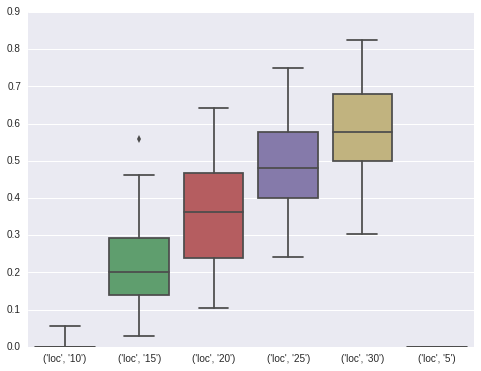

In [58]:
bad_pcs = pd.DataFrame(bad_pcs)
plt.figure(figsize=(8,6))
sns.boxplot(bad_pcs)

In [59]:
##project out the bad components
def clean_data(in_tuple):
    threshold = '20'
    sub, exp, run = in_tuple

    sub_path = home_dir + 'analysis/' + exp + '/' + sub + '/preproc/run_' + run + '/'

    mel_path = sub_path + '/melodic'

    thresh_file = mel_path +'/fix4melview_WhII_MB6_thr' + threshold + '.txt'
    cmd_str = fix_cmd + ' -a ' + thresh_file 
    new_file = mel_path + '/filtered_func_data_clean.nii.gz'
    if os.path.exists(sub_path):# and not os.path.exists(new_file):
        os.system(cmd_str)
# clean_data(in_tuples[0])

In [ ]:
dview = rc[0:6]
dview.block = True

dview.push(dict(home_dir = home_dir,
                fix_cmd = fix_cmd))
dview.execute("import numpy as np")
with dview.sync_imports():
    import os
    import numpy
    from nipype.interfaces.fsl import MELODIC

dview.map_sync(clean_data,in_tuples)

importing os on engine(s)
importing numpy on engine(s)
importing MELODIC from nipype.interfaces.fsl on engine(s)


In [ ]:
sub_paths = []
masks = []
for in_tuple in in_tuples:
    sub, exp, run = in_tuple

    sub_path = op.join(home_dir,'analysis', exp, sub, 'preproc','run_' + run + '/')
    sub_paths.append(op.join(sub_path,'melodic','filtered_func_data_clean.nii.gz'))
    masks.append(sub_path + 'functional_mask.nii.gz')
    
smoothwf = create_susan_smooth()

smoothwf.inputs.inputnode.in_files = sub_paths
smoothwf.inputs.inputnode.mask_file = masks
smoothwf.inputs.inputnode.fwhm = 4
smoothwf.base_dir = op.join(home_dir,'analysis','susan_smooth')

smoothwf.run('MultiProc', plugin_args={'n_procs': 16})


In [24]:
smooth_path = op.join(home_dir,'analysis', 'susan_smooth',
                      'susan_smooth','smooth','mapflow') 

for n,s in enumerate(glob.glob(smooth_path + '/*')):
    a = np.loadtxt(s + '/command.txt',dtype= 'str')
    p = '/'.join(a[1].split('/')[0:-2])
    old = op.join(s,'filtered_func_data_clean_smooth.nii.gz')
    new_path = op.join(p,'smoothed_timeseries.nii.gz')
    
    cmd = ['ln','-s',old,new_path]
    os.system(' '.join(cmd))

In [27]:
for in_tuple in in_tuples:
    sub, exp, run = in_tuple
    
    sub_path = op.join(home_dir,'analysis', exp ,
                       sub, 'preproc','run_' + run)
    

    if os.path.exists(sub_path):
        
        #check to see if smoothed data are there
        smoothed = op.join(sub_path,'smoothed_timeseries.nii.gz')
        if not op.exists(smoothed):
            print smoothed
        
        #make directory for old data
        new_dir = op.join(sub_path, 'uncleaned_data')
        if not os.path.exists(new_dir):
            os.mkdir(new_dir)

        #move old lyman files inside new_dir if they arent there already
        old_smooth = op.join(sub_path, 'unsmoothed_timeseries.nii.gz')
        
        if not os.path.exists(op.join(new_dir,'unsmoothed_timeseries.nii.gz')):
            shutil.move(old_smooth,new_dir)

        #create a symbolic link to cleaned and smoothed data
        if not os.path.exists(old_smooth):
            cmd_str = ['ln','-s', 
                       op.join(sub_path,'melodic','filtered_func_data_clean.nii.gz'),
                       old_smooth]
            cmd_str = ' '.join(cmd_str)
            os.system(cmd_str)
        else:
            print sub_path